<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualization-dataset" data-toc-modified-id="Visualization-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualization dataset</a></span></li><li><span><a href="#Set-up-experiment-parameters" data-toc-modified-id="Set-up-experiment-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set up experiment parameters</a></span></li><li><span><a href="#DR-RBF" data-toc-modified-id="DR-RBF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DR-RBF</a></span></li><li><span><a href="#DR-Matern" data-toc-modified-id="DR-Matern-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>DR-Matern</a></span></li><li><span><a href="#DR-GA" data-toc-modified-id="DR-GA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>DR-GA</a></span></li><li><span><a href="#KES" data-toc-modified-id="KES-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>KES</a></span></li><li><span><a href="#SES" data-toc-modified-id="SES-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>SES</a></span><ul class="toc-item"><li><span><a href="#DeepSets" data-toc-modified-id="DeepSets-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>DeepSets</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Lead-lag-transform" data-toc-modified-id="Lead-lag-transform-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Lead-lag transform</a></span></li></ul></div>

In [1]:
import sys
sys.path.append('../src')

import time
import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import utils_roughvol

import DR_RBF
import DR_GA
import DR_Matern
import KES
import SES
import sklearn_transformers
import deep_sets


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 4),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import pickle

/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We assume that prices follow the following fractional OU process

$$dX_t =  -\alpha(X_t - \mu) + \nu dW^H_t$$

where $W^H_t$ is fBM with H<0.5. This RDE has an explicit solution

$$X_t = \nu \int_{-\infty}^t e^{-\alpha(t-s)}dW_s^H + \mu$$

The Rough Fractional Stochastic Volatility (RFSV) model is defined in https://arxiv.org/pdf/1410.3394.pdf as follows

$$\sigma_t = e^{X_t}$$

# Visualization dataset

In [2]:
tot = 15
l = 100

a1 = 0.00001
a2 = 0.001
a3 = 0.1

list_df_prices = []
list_df_vols = []

for a in [a1, a2, a3]:
    
    df = pd.DataFrame(data=[utils_roughvol.fOU_generator(a,length=l) for k in range(tot)], 
                      columns=range(l+1)).T
    list_df_prices.append(df)

    list_df_vols.append(df.apply(lambda x: np.exp(x)))

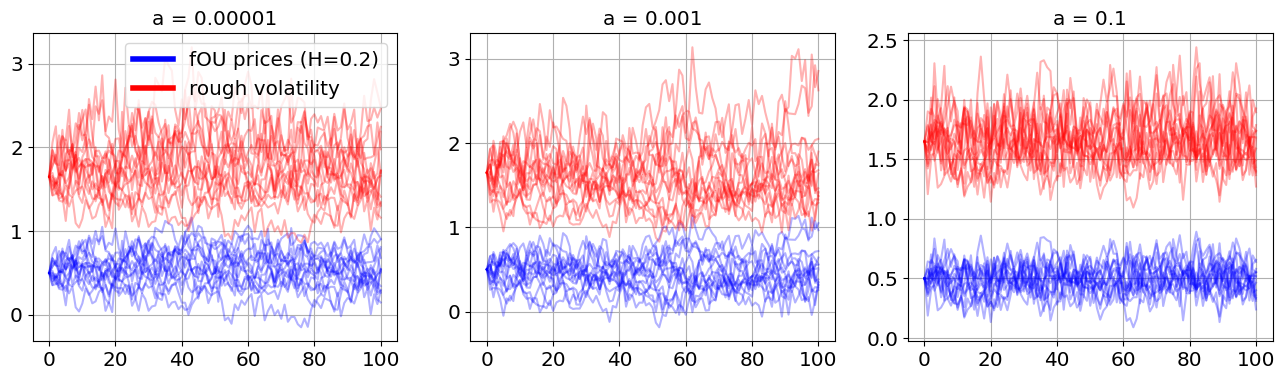

In [3]:
custom_lines = [Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='red', lw=4)]

fig, ax = plt.subplots(1, 3)

k=0
for df_p, df_v, a, axx in zip(list_df_prices, list_df_vols, [a1,a2,a3], ax.flatten()):
    if a<1e-4:
        title = 'a = {:.5f}'.format(a)
    else:
        title = 'a = {}'.format(a)
    df_p.plot(grid=True, title=title, legend=False, c='blue', alpha=0.3, ax=axx)
    df_v.plot(grid=True, legend=False, c='red', alpha=0.3, ax=axx)
    if k==0:
        axx.legend(custom_lines, ['fOU prices (H=0.2)', 'rough volatility'])
    k+=1

#plt.savefig('../pictures/fOU_rough_vol.png', bbox_inches='tight')
plt.show()

# Set up experiment parameters

In [4]:
M = 50
N = 20 # change to 20, 50, 100 to reproduce the experiments
length = 200

max_T = 1e0
min_T = 1e-6
np.random.seed(0)
y = np.array((max_T-min_T)*np.random.rand(M)+min_T)

In [5]:
X = []
    
for a in tqdm(y):
    intermediate = []
    for n in range(N):
        path = np.exp(utils_roughvol.fOU_generator(a, length=length)).reshape(-1,1)
        intermediate.append(path)
    X.append(intermediate)

100%|██████████| 50/50 [00:02<00:00, 24.00it/s]


In [6]:
P = []
for x in X:
    intermediate = []
    for vol_path in x:
        # generate brownian increments over [0, 1] (like utils_roughvol.fOU_generator)
        deltaW = np.random.normal(0, np.sqrt(1/length), size=(length, 1))
        price_path = np.zeros_like(vol_path)
        price_path[0, :] = np.ones(1)
        for i in range(1, length+1):
            price_path[i, :] = price_path[i-1, :]*(1 + vol_path[i, :]*deltaW[i-1, :])
        intermediate.append(price_path)
    P.append(intermediate)

# DR-RBF

In [6]:
m_mse, std_mse, results_RBF = DR_RBF.model(X,y,ll=[0],at=True,mode='krr',NUM_TRIALS=5,cv=3) 

100%|██████████| 5/5 [04:42<00:00, 56.56s/it]


# DR-Matern

In [7]:
m_mse, std_mse, results_Matern = DR_Matern.model(X,y,at=True,mode='krr',NUM_TRIALS=5,cv=3) 

100%|██████████| 5/5 [04:04<00:00, 48.98s/it]


# DR-GA

In [8]:
m_mse, std_mse, results_GA = DR_GA.model(X,y,at=True,mode='krr',NUM_TRIALS=5,ll=[0],cv=3,lambdas=[0.01])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed: 19.1min finished


best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01
best lambda (cv on the train set):  0.01


# KES

In [9]:
m_mse, std_mse, results_KES = KES.model(X, y,  ll=[0], at=True, scales=[0.35], mode='krr', NUM_TRIALS=5,  cv=3)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:  9.9min finished
 20%|██        | 1/5 [00:00<00:01,  2.87it/s]

best scaling parameter (cv on the train set):  0.35


 40%|████      | 2/5 [00:00<00:01,  2.73it/s]

best scaling parameter (cv on the train set):  0.35


 60%|██████    | 3/5 [00:01<00:00,  2.81it/s]

best scaling parameter (cv on the train set):  0.35


 80%|████████  | 4/5 [00:01<00:00,  2.80it/s]

best scaling parameter (cv on the train set):  0.35


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

best scaling parameter (cv on the train set):  0.35


# SES

In [7]:
m_mse, std_mse, results_SES = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=[0], at=True, NUM_TRIALS=5, cv=3)

  0%|          | 0/5 [00:00<?, ?it/s]/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-03, tolerance: 2.016e-04
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.418e-03, tolerance: 2.431e-04
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/skl

best truncation level (cv on train set):  3


/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-02, tolerance: 1.020e-03
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e-02, tolerance: 9.612e-04
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

best truncation level (cv on train set):  3


/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.578e-03, tolerance: 2.033e-04
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.774e-03, tolerance: 1.032e-03
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

best truncation level (cv on train set):  2


/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.028e-02, tolerance: 1.002e-03
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.834e-03, tolerance: 1.065e-03
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

best truncation level (cv on train set):  3


/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-02, tolerance: 9.013e-04
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.111e-03, tolerance: 1.051e-03
  model = cd_fast.enet_coordinate_descent(
/rds/general/user/ll1917/home/anaconda3/envs/esig-distribution-regression-streams-env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent

best truncation level (cv on train set):  3


In [1]:
import sklearn

sklearn.__version__

'1.5.2'

## DeepSets

In [ ]:
# batch_size = 100
# nb_epoch = 500
# importlib.reload(deep_sets)
# data = X.copy()

# ll = None
# at = True

# from sklearn_transformers import AddTime, LeadLag
# if ll is not None:
#     data = LeadLag(ll).fit_transform(data)
# if at:
#     data = AddTime().fit_transform(data)

In [ ]:
# MSEs = []
# results_deepsets = []

# start = time.time()
# for j in range(5):
    
#     X_train, X_test, y_train, y_test = train_test_split([[x.reshape(-1) for x in xx] for xx in data], y, test_size=0.2, random_state=j)
#     np.random.seed(0)
    
#     # augment data
#     X_train_aug = X_train
#     y_train_aug = y_train
#     X_train_aug = []
#     y_train_aug = []
#     for k,bag in enumerate(X_train):
#         for i in range(10):
#             X_train_aug.append(np.array(bag)+np.random.rand())
#             y_train_aug.append(y_train[k]+1e-7*np.random.rand())

    
#     train = deep_sets.DataIterator(torch.Tensor(X_train_aug), torch.Tensor(y_train_aug), batch_size, shuffle=True)
#     test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

#     model = deep_sets.DeepSet
    
#     t = deep_sets.Trainer(train.d, model, nb_epoch)
#     t.fit(train,test)
    
#     res = t.evaluate(test)
#     MSEs.append(res)
    
#     res_full = t.evaluate(test,return_all=True)
#     results_deepsets.append(res_full)


# end = time.time()

# print('time', end-start)
# print(np.mean(MSEs), np.std(MSEs))

# Results

In [9]:
from utils import mape as mape
from utils import mse as mse

In [ ]:
print('DR-RBF', mape(results_RBF))
print('DR-Matern', mape(results_Matern))
print('DR-GA',mape(results_GA))
print('KES',mape(results_KES))
print('SES',mape(results_SES))
# print('DeepSets',mape(results_deepsets))

In [ ]:
print('DR-RBF', mse(results_RBF))
print('DR-Matern', mse(results_Matern))
print('DR-GA',mse(results_GA))
print('KES',mse(results_KES))
print('SES',mse(results_SES))
# print('DeepSets',mse(results_deepsets))

In [11]:
print('SES',mse(results_SES))

SES (0.0014879975622053912, 0.0003906385440366097)


**Save results**

In [8]:
results = {'rbf':results_RBF, 'Matern':results_Matern, 'GA':results_GA, 'KER':results_KES, 'SES':results_SES}
pickle.dump(results, open(f'finance_{N}_length200.obj','wb'))

In [16]:
with open('finance_20_length200.obj', 'rb') as f:
    results = pickle.load(f)
for model in results:
    print(model, mse(results[model]))

rbf (0.04802037310059486, 0.011255911195820754)
Matern (0.04862086271921343, 0.010295419115773816)
GA (0.0011043035295142585, 0.00027777355753927797)
KER (0.0014155545800416812, 0.00040210040501273555)
SES (0.0014879975622053732, 0.0003906385440365881)


# Lead-lag transform

In [ ]:
X = np.array([1,5,3,6])[:,None]
a = LeadLag([0]).fit_transform([[X]])

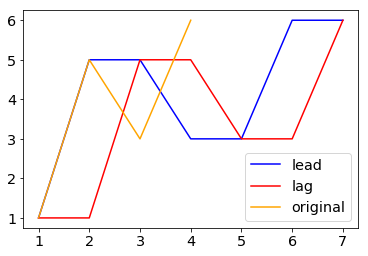

In [ ]:
plt.plot(np.arange(1,8),a[0][0][:,0],color='blue',label='lead')
plt.plot(np.arange(1,8),a[0][0][:,1],color='red',label='lag')
plt.plot(np.arange(1,5),X[:,0],color='orange',label='original')
plt.legend()
plt.show()

## Martingale Variance Reduction SES

Compare SES with lead-lag to SES without lead-lag.

In [18]:
X=P

In [26]:
m_mse, std_mse, results_SES = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=None, at=True, NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:01<00:04,  1.16s/it]

best truncation level (cv on train set):  2


 40%|████      | 2/5 [00:02<00:03,  1.18s/it]

best truncation level (cv on train set):  2


 60%|██████    | 3/5 [00:04<00:02,  1.40s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [00:05<00:01,  1.33s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]

best truncation level (cv on train set):  2


In [19]:
m_mse, std_mse, results_SES_ll = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=[0], at=True, NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:26<01:46, 26.50s/it]

best truncation level (cv on train set):  2


 40%|████      | 2/5 [00:51<01:16, 25.45s/it]

best truncation level (cv on train set):  2


 60%|██████    | 3/5 [01:16<00:50, 25.38s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [01:43<00:26, 26.01s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [02:09<00:00, 26.00s/it]

best truncation level (cv on train set):  4


In [21]:
m_mse, std_mse, results_SES_martingale = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=None, martingale_indices=[0], at=True, NUM_TRIALS=5, cv=3)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:01<00:05,  1.46s/it]

best truncation level (cv on train set):  4


 40%|████      | 2/5 [00:03<00:04,  1.55s/it]

best truncation level (cv on train set):  2


 60%|██████    | 3/5 [00:04<00:02,  1.48s/it]

best truncation level (cv on train set):  2


 80%|████████  | 4/5 [00:05<00:01,  1.49s/it]

best truncation level (cv on train set):  4


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]

best truncation level (cv on train set):  2


In [22]:
m_mse, std_mse, results_SES_ll_martingale = SES.model(X, y, depths1=[2,3,4], depth2=2, ll=[0], martingale_indices=[0], at=True, NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:24<01:37, 24.45s/it]

best truncation level (cv on train set):  2


 40%|████      | 2/5 [00:49<01:14, 24.80s/it]

best truncation level (cv on train set):  2


 60%|██████    | 3/5 [01:14<00:49, 24.67s/it]

best truncation level (cv on train set):  4


 80%|████████  | 4/5 [01:38<00:24, 24.40s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [02:02<00:00, 24.40s/it]

best truncation level (cv on train set):  4


In [23]:
from utils import mse as mse
print('SES',mse(results_SES))
print('SES_ll',mse(results_SES_ll))
print('SES_martingale',mse(results_SES_martingale))
print('SES_ll_martingale',mse(results_SES_ll_martingale))

SES (0.06457646650587764, 0.03245769897741194)
SES_ll (0.06106664121779439, 0.023451799673163323)
SES_martingale (0.05180480820141291, 0.010925018174995806)
SES_ll_martingale (0.06250956978795225, 0.02736238034861562)


## When X is volatility process (not a martingale)
SES (0.021218680540370956, 0.019863264115152535)
SES_martingale (0.007636434007609476, 0.00350361730437619)
SES_ll (0.0014879975622053732, 0.0003906385440365881)
SES_ll_martingale (0.001261397231185329, 0.00048341187830020036)

## When X is price process under Q (a martingale) -- harder task!
SES (0.06457646650587764, 0.03245769897741194)
SES_martingale (0.05180480820141291, 0.010925018174995806)
SES_ll (0.06106664121779439, 0.023451799673163323)
SES_ll_martingale (0.06250956978795225, 0.02736238034861562)